In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import string
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
batch_size = 16
#vocabs = ' ' + string.digits + string.ascii_letters + string.punctuation + '°£€¥¢฿'

vocabs = ' ' + "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!#$%&'()+,-.;=@[]^_`{}~°£€¥¢"

CHAR2LABEL = {char: i for i, char in enumerate(vocabs)}
LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [106]:
class TextDataset(Dataset):
    
    def __init__(self, data_dir, image_names, test_mode=False):
        self.data_dir = data_dir
        self.image_names = image_names
        self.test_mode = test_mode
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path).convert('L')
        if self.test_mode:
          im_k = 32/image.size[1]

          image = image.resize((int(image.size[0]*im_k), 32), resample=Image.BILINEAR) # resize for model
          
        else:
          image = image.resize((600, 32), resample=Image.BILINEAR) # resize for model

        text = image_name[:-len('.png')]

        text = [CHAR2LABEL[i] for i in text]

        image = self.transform(image)
        #print(image.size())
        #text = text + [0] * (45 - len(text))
        text = torch.LongTensor(text)
        
        
        
        text_length = [len(text)]
        text_length = torch.LongTensor(text_length)
        return image, text, text_length
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            AddGaussianNoise(0., .08 if self.test_mode else 0.)
            #transforms.Normalize()
        ])
        return transform_ops(image)

In [107]:
data_path = '/content/drive/MyDrive/im'
image_names = os.listdir(data_path)

In [108]:
new_names = []
for i in image_names:
  if len(i) == 24:
    new_names.append(i)

image_names = new_names

In [109]:
image_names_train, image_names_test = train_test_split(image_names, random_state=0)
print(len(image_names_train), len(image_names_test))

trainset = TextDataset(data_path, image_names_train)
testset = TextDataset(data_path, image_names_test)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

2235 745


In [110]:
set([len(i) for i in image_names])

{24}

In [111]:

for i in image_names:
  if i[-4:] != '.png': print(i)

In [112]:
iter(train_loader).next()
None

In [113]:
class CRNN(nn.Module):
    
    def __init__(self, voc_len):
        super(CRNN, self).__init__()

        self.voc_len = voc_len

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2), stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d((1, 2), stride=2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)
        
        self.norm = nn.BatchNorm2d(512)

        self.rnn1 = nn.LSTM(input_size=512,hidden_size=256, bidirectional=True)
        self.rnn2 = nn.LSTM(input_size=512,hidden_size=256, bidirectional=True)
      
        self.linear1 = nn.Linear(512, 512) 
        self.linear2 = nn.Linear(512, self.voc_len)
        
        
        
    def forward(self, images):

        images = F.relu(self.conv1(images))
        images = self.pool1(images)
        images = F.relu(self.conv2(images))
        images = self.pool2(images)
        images = F.relu(self.conv3(images))
        images = F.relu(self.conv4(images))
        images = self.pool3(images)
        images = F.relu(self.conv5(images))
        
        images = self.norm(images)
        images = F.relu(self.conv6(images))
        images = self.norm(images)

        images = self.pool4(images)
    
        images = F.relu(self.conv7(images))
        
      
        batch, channel, height, width = images.size()

        images = images.view(batch, channel * height, width)
        images = images.permute(2, 0, 1)  # (width, batch, feature)
        
        images = self.linear1(images)

        #rnn
        rnn, _ = self.rnn1(images)
        rnn, _ = self.rnn2(rnn)

        out = self.linear2(rnn)
        
        return out

In [114]:
model = CRNN(len(vocabs))
model.to(device)

CRNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn

In [115]:
criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [116]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    #targets = torch.Tensor(list(targets))


    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    return loss.item()

In [117]:
epochs = 100

epoch_losses = []
num_updates_epochs = []
flag = True

for epoch in range(1, epochs + 1):
      print(f'epoch: {epoch}', end='\t')
      tot_train_loss = 0.
      tot_train_count = 0
      if flag == False: break
      for train_data in train_loader:
          
          loss = train_batch(model, train_data, optimizer, criterion, device)

          epoch_losses.append(loss)
          num_updates_epochs.append(epoch)

          train_size = train_data[0].size(0)

          tot_train_loss += loss
          tot_train_count += train_size

          if tot_train_loss / tot_train_count < 5e-5: 
            flag = False
            break
          
      #lr_scheduler.step(tot_train_loss / tot_train_count)
      #scheduler.step()
      print('train_loss: ', tot_train_loss / tot_train_count)

epoch: 1	train_loss:  0.29208123635925703
epoch: 2	train_loss:  0.2562460960157766
epoch: 3	train_loss:  0.11647902311094656
epoch: 4	train_loss:  0.037249112182548914
epoch: 5	train_loss:  0.015546122616702811
epoch: 6	train_loss:  0.00880766247276225
epoch: 7	train_loss:  0.006512664763519428
epoch: 8	train_loss:  0.004778919297310063
epoch: 9	train_loss:  0.0037215636563914466
epoch: 10	train_loss:  0.002883308164992055
epoch: 11	train_loss:  0.0021648417891605323
epoch: 12	train_loss:  0.0023448716869923624
epoch: 13	train_loss:  0.0019762878454138233
epoch: 14	train_loss:  0.0015779680497444316
epoch: 15	train_loss:  0.0013448699969189947
epoch: 16	train_loss:  0.0011202831454658402
epoch: 17	train_loss:  0.001108549790502728
epoch: 18	train_loss:  0.0012428112669745815
epoch: 19	train_loss:  0.001428860637632259
epoch: 20	train_loss:  0.0008662809958468947
epoch: 21	train_loss:  0.0008562778487334849
epoch: 22	train_loss:  0.0008396686488133283
epoch: 23	train_loss:  0.0007558045

Text(0, 0.5, 'Loss')

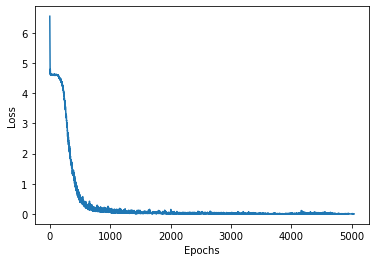

In [118]:
fig, ax = plt.subplots()

ax.plot(epoch_losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")


In [119]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [LABEL2CHAR[int(idx)] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [120]:
def real_text(text_tokens):
    text_tokens = text_tokens.numpy()
    tr = []
    for text_token in text_tokens:
        text = [LABEL2CHAR[int(idx)] for idx in text_token]
        text = "".join(text)
        tr.append(text)
    return tr

In [121]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split(" ")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [122]:
test = []
pred = []
with torch.no_grad():
    for image_batch, text_batch, _ in tqdm(test_loader, leave=True):
        text_batch_logits = model(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        
        text_batch_pred = decode_predictions(text_batch_logits.cpu())

        #print(real_text(text_batch), text_batch_pred)
        test += real_text(text_batch) 
        pred += text_batch_pred

  0%|          | 0/47 [00:00<?, ?it/s]

In [123]:
pred = [correct_prediction(t) for t in pred]

In [124]:
accuracy_score(test, pred)

0.7651006711409396

In [125]:
new_text = '/content/drive/MyDrive/forward'
new_ds = TextDataset(new_text,['0orERvaY9C.png'], test_mode=True)
new_dl = DataLoader(new_ds, batch_size=1)

In [126]:
im, tx, ln = [d.to(device) for d in iter(new_dl).next()]

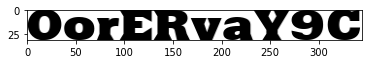

In [127]:
plt.imshow(Image.open('/content/drive/MyDrive/forward/0orERvaY9C.png'))
plt.show()

In [128]:
im[0][0].shape

torch.Size([32, 356])

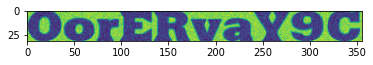

In [129]:
plt.imshow(im[0][0].cpu().numpy())
plt.show()

In [130]:
with torch.no_grad():
  res = model(im)
  text_pred = decode_predictions(res.cpu())
  tx_pr = correct_prediction(text_pred[0])

In [132]:
real_text(tx.cpu())[0]

'0orERvaY9C'

orig: Wlg¥.5G)LNygM2lnk9W{,	pred: Wlg¥.5G)LNygM2lnk9W{


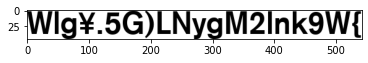

orig: 3£V'm(8]}%E;03WD9ZY=,	pred: 3£V'm(8]}%E;03WD9ZY=


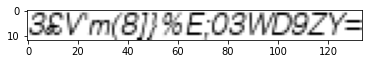

orig: @¥yA=[^eH¢GlJe}bp}]7,	pred: @¥yA=[^eH¢GlJe}bp}]7


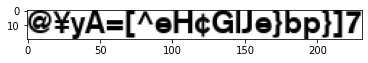

orig: K_xg=NaFY¢o5H@HykgB},	pred: K_xg=NaFY¢o5H@HykgB}


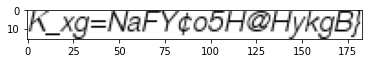

orig: $€+1,-¥Xni)$+A$7!,~0,	pred: $€+1,-¥Xni)$+A$7!,~0


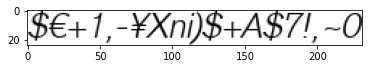

In [133]:
for i, v in enumerate(test[:5]):
    print(f'orig: {v},\tpred: {pred[i]}')
    img = Image.open(os.path.join(data_path, v +'.png'))
    plt.imshow(img)
    plt.show()

orig: g(¥C€X0MD=MFsB_QuOuu,	pred: g(¥C€X0MD=MFsB_QuOu


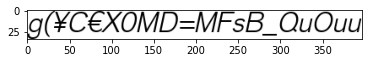

orig: Y9.)(bT)6fjF.&~APMi€,	pred: Y9.(bT)6fjF.&~APMi€


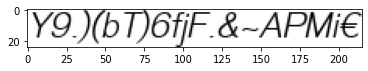

orig: 91'3@2d8'F%}k~lHbnX£,	pred: 91'3@2d8'F%}k~IHbnX£


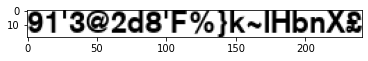

orig: lx8QDbM;-5%SFh],R£WI,	pred: lx8QDbM;-5%SFh],R£Wl


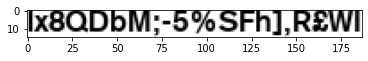

orig: Rq}Kp2$2¢S5`ldEI4O`+,	pred: Rq}Kp2$2¢S5`IdEl4O`+


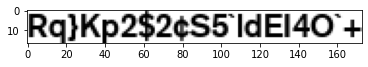

orig: ,(d;lOkhX£Q@YAQ3l-0E,	pred: ,(d;lOkhX£Q@YAQ3I-0E


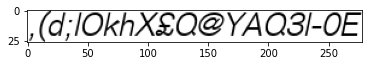

orig: @Ai-V~`Z4df8£¥y^;l}_,	pred: @Ai-V~`Z4df8£¥y^;I}_


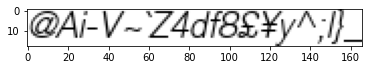

orig: J)r&^S-aIYAmP€@qg;MA,	pred: J)r&^S-alYAmP€@qg;MA


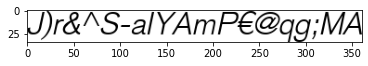

orig: bznT^If}A1w8mfdg@{D;,	pred: bznT^lf}A1w8mfdg@{D;


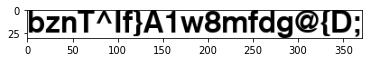

orig: €mooE¢_=MJeQl}I¢[zC#,	pred: €mooE¢_=MJeQI}I¢[zC#


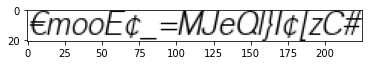

orig: zTc}0ISl{7M{rX,r]U9w,	pred: zTc}0ISI{7M{rX,r]U9w


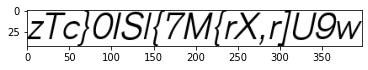

orig: Zzmu€5mOW~q°u#CrC¥58,	pred: Zzmu€5mOW~q°u#CnC¥58


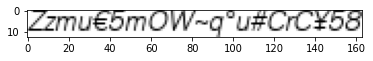

orig: g_P}@3UtLZI=i@hZYip1,	pred: g_P}@3UtLZl=i@hZYip1


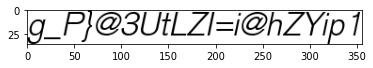

orig: pUU,Q))5RZc]Eqbjni%X,	pred: pUU,Q)5RZc]Eqbjni%X


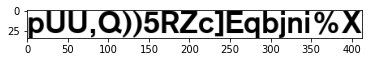

orig: n°29RjQ.(lNxhlkq¢kYS,	pred: n°29RjQ.(INxhlkq¢kYS


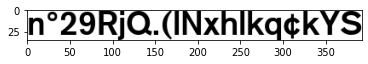

orig: $lH{LXQ)`L8€@Qf)£,	pred: $IH{LXQ)`L8€@Qf)£


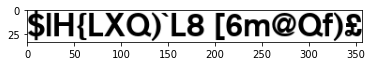

orig: g!cdyiitZO7+wOhF%@`v,	pred: g!cdyitZO7+wOhF%@`v


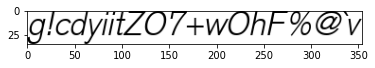

orig: bEIfRs)XPhmU$6`M1€}y,	pred: bEfRs)XPhmU$6`M1€}y


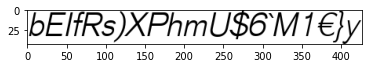

orig: Ij¥zSY!&QI-f5OwQwan€,	pred: j¥zSY!&QI-fOwQwan€


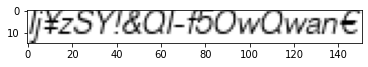

orig: BO#`[$£OILm]£7B4V`C!,	pred: BO#`[$£OlLm]£7B4V`C!


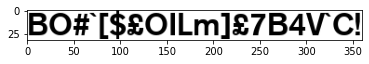

orig: .YESlI0#k[€.43U!7bW¢,	pred: .YESl0#k[€.43U!7bW¢


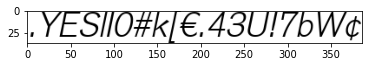

orig: ljJ)2md$°{°V3+s6V${O,	pred: lJ)2md$°{°V3+s6V${O


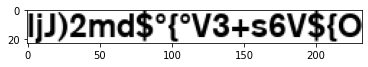

orig: `tCO4h]g£o`;geU%0eK5,	pred: `CO4h]g£o`;geU%0eK5


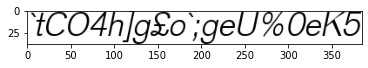

orig: ny}fz5e^@&°IUYQgzC'I,	pred: ny}fz5e^@&°IUYQgzC'


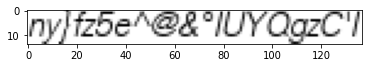

orig: I$86b8¥2°XgnM`B^A@}p,	pred: l$86b8¥2°XgnM`B^A@}p


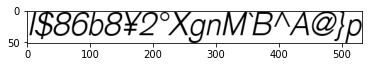

orig: £_$@0-VZVt2c]¢]€_X@J,	pred: £_$@0-VZVt2c]¢]_X@J


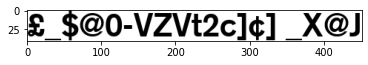

orig: I€7P~0HVUa°9}4;ofFsf,	pred: l€7P~0HVUa°9}4;ofFsf


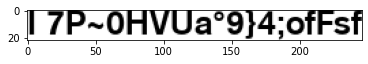

orig: #gtm¢.Oy£0Y@iX=¥f¢20,	pred: #gtm¢.Oy£0Y@lX=¥f¢20


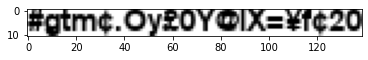

orig: DKZI&$Y{x7!kUG1]B°l(,	pred: DKZl&$Y{x7!kUG1]B°(


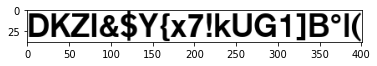

orig: Jp1a91ff€&e1g+%i~x6=,	pred: Jp1a91f€&e1g+%i~x6=


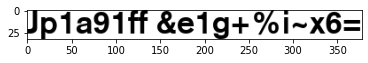

orig: $a¢w°fTbI'(=k~-1mIW€,	pred: $a¢w°fTbl'(=k~-1mIW€


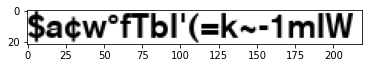

orig: `6tc[w.)e¥{R,4JwlVrs,	pred: `6tc[w.)e¥{R,4JwIVrs


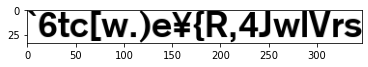

orig: pU!x9}k}aaL`n`I¢N+GE,	pred: pU!x9}k}aaL`n`l¢N+GE


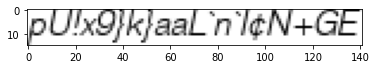

orig: lO!s£W,i.¢D,^&F78e4%,	pred: lO!s£W,l.¢D,^&F78e4%


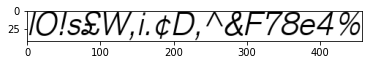

orig: PrXd,QaI1¥T%&8[K(&p9,	pred: PrXd,Qal1¥T%&8[K(&p9


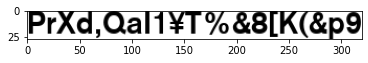

orig: wa{{3^YVA[Eb(¥£lPG-X,	pred: wa{3^YVA[Eb(¥£lPG-X


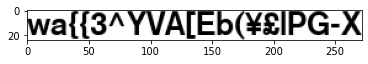

orig: a)F]u=a¢MsT'^Lwo..7],	pred: a)F]u=a¢MsT'^Lwo.7]


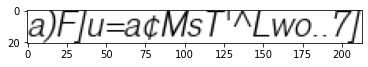

orig: ]Z@6ZVI.%96^M£XLOzU[,	pred: ]Z@6ZVl.%96^M£XLOzU[


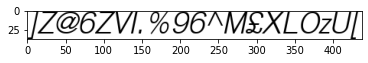

orig: vhD+gFEc8!W'kxykb-.`,	pred: vhD+gFEc8!W'kxykb-`


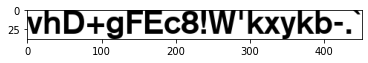

orig: ~W9aQ~B[+.--)AX-6dek,	pred: ~W9aQ~B[+.-)AX-6dek


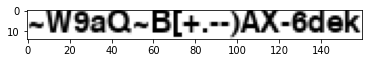

orig: M$DCH$BR£~TKUv%cDc.6,	pred: M$DCH$BR£~TKUy%cDc.6


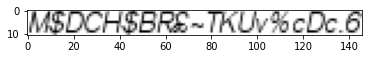

orig: 5&zVI1`L,5f£R%Rz,Nlv,	pred: 5&zVI1`L,5f£R%Rz,NIv


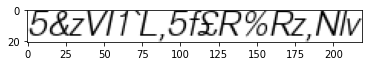

orig: i}8z71QU!YBkFsP¥^F16,	pred: i]8z71QU!YBkFsP¥^F16


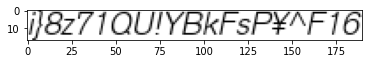

orig: ^¢$vdqJw~8B;n]irC;l},	pred: ^¢$vdqJw~8B;n]irC;}


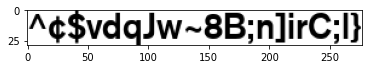

orig: -RvilL¢wr';#1]a&vp[i,	pred: -RviIL¢wr';#1]a&vp[i


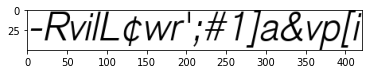

orig: _c1€Sn}mOd!¢@4IdWfbT,	pred: _c1€Sn}mOd!¢@4ldWfbT


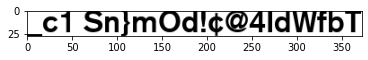

orig: =T0Y¢IQl(~,%#]+£U%bg,	pred: =T0Y¢lQl(~,%#]+£U%bg


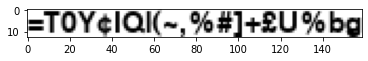

orig: g9B'JFG-RaS£$lZ,,!XE,	pred: g9B'JFG-RaS£$lZ,!XE


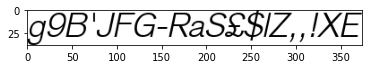

orig: A7%-`¢ZbpQaL~dJc6la8,	pred: A7%-`¢ZbpQaL~dJc6Ia8


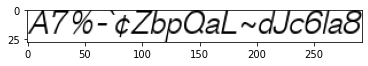

orig: i[VG[,3'$GI%JXP_ff{j,	pred: i[VG[,3'$GI%JXP_f{j


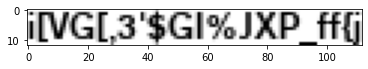

orig: ]jjY^3Pduz7!}`43vY]_,	pred: ]jY^3Pduz7!}`43vY]_


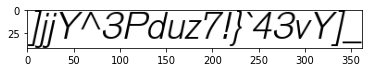

orig: ej°.sFD`$€k'l6¥uzHdp,	pred: ej°.sFD`$€k'I6¥uzHdp


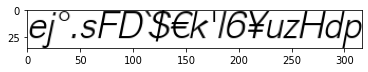

orig: .TAXKUsWK)XG°Do^Vk==,	pred: .TAXKUsWK)XG°Do^Vk=


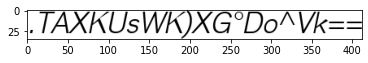

orig: nTOIgZ1Ahk`.RZn8za5j,	pred: nTOlgZ1Ahk`.RZn8za5j


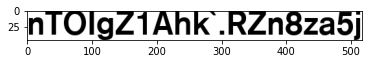

orig: JF+ojs7I%^RM_+llOCES,	pred: JF+ojs7I%^RM_+lIOCES


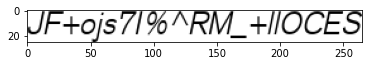

orig: mTx@;MB;;3Rzz%4j9@4T,	pred: mTx@;MB;;3Rz%4j9@4T


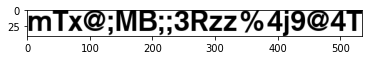

orig: QbD7lkfZTe&kEBU2M$.9,	pred: QbD7IkfZTe&kEBU2M$.9


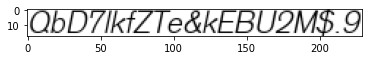

orig: Q2po7}{~£-IU%w10yp2u,	pred: Q2po7}{~£-lU%w10yp2u


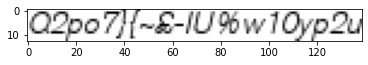

orig: W#iFfN¥w¢DT]°DP554xo,	pred: W#lFfN¥w¢DT]°DP554xo


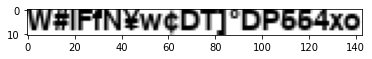

orig: ¥ZgV7@b&#%}!I7y;¥=a-,	pred: ¥ZgV7@b&#%}!l7y;¥=a-


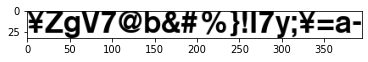

orig: 3Y@`l(£3kC.Sp_E!ZET+,	pred: 3Y@`(£3kC.Sp_E!ZET+


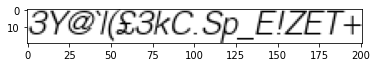

orig: %tzl-dmlPsC%r]8¥8o¥d,	pred: %tzl-dmIPsC%r]8¥8o¥d


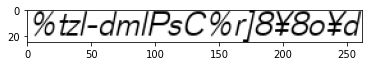

orig: {°7fiR€isj,gExDj¥R¥l,	pred: {°7fiR€isj,gExDj¥R¥I


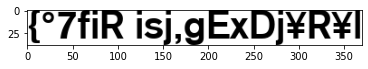

orig: %fV#[qoq_}F_A'(l5rI',	pred: %fV#[qoq_}F_A'(I5r'


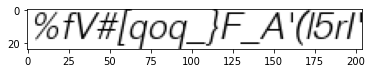

orig: kO.d@z(}A%A4I£e%qvx%,	pred: kO.d@z(}A%A4l£e%qvx%


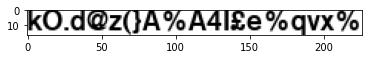

orig: AM!Wda2}G02ai='Q@)){,	pred: AM!Wda2}G02ai='Q@){


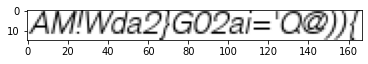

orig: 'cclAt5X5bS6k1%CFb°1,	pred: 'clAt5X5bS6k1%CFb°1


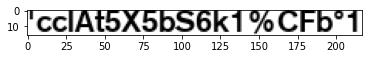

orig: +cYwOBV#B5YOI}{U9+$T,	pred: +cYwOBV#B5YOl}{U9+$T


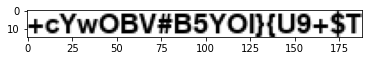

orig: Kl¥j=HuErvUw°-8},a}r,	pred: KI¥j=HuErvUw°-8},a}r


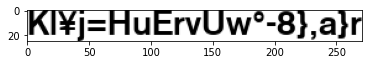

orig: aC8_eS1r[IpP¢%{Fd)`Z,	pred: aC8_eS1rIjpP¢%{Fd)`Z


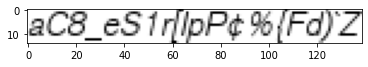

orig: ma]E,p72aWSri¥p3`~nM,	pred: ma]E,p72aWSn¥p3`~nM


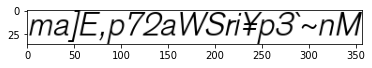

orig: b5#Ndd#Y'JnR!lBr!ex',	pred: b5#Ndd#Y'JnR!IBr!ex'


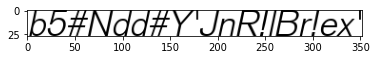

orig: xsk03%Y4gBJ[I)¥LpfQY,	pred: xsk03%Y4gBJ[l)¥LpfQY


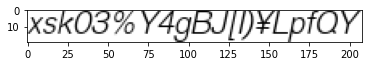

orig: !yQbtz£Q3Ah#(}SP-}@@,	pred: ,yQbtz£Q3Ah#(}SP-}@@


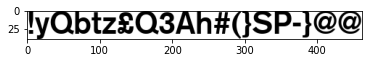

orig: b.1ajCdb[pyO!£mnUQf},	pred: b.1ajCdb[pyO!£mnUQ}


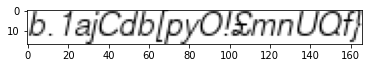

orig: x9'D)N]KLQLAz+!%#Wi],	pred: x9'D)N]KLQLAz+!%#Wij


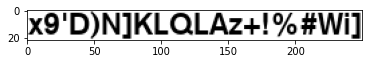

orig: m7[[@fA)£=S$qa$q@u7@,	pred: m7[@fA)£=S$qa$q@u7@


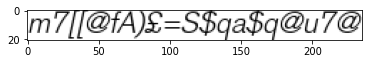

orig: I!3jjkxX3W~¥H2k¢q`mU,	pred: I!3jkxX3W~¥H2k¢q`mU


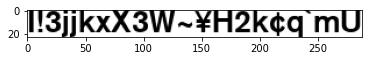

orig: 6RJml&abZQskHI!J,62),	pred: 6RJmI&abZQskHI!J,62)


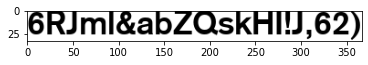

orig: sa&~.1¢6FUJGw%Cv;!%^,	pred: s&~.1¢6FUJGw%Cv;!%^


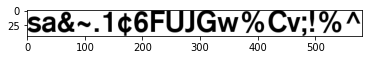

orig: 4LG+su~_Y&Z8Q'o-KMu8,	pred: 4LG+su~_Y&Z8Q`o-KMu8


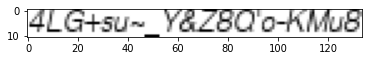

orig: t1.;OI°3&J¢KZ0h%63'¥,	pred: t1.;Ol°3&J¢KZ0h%63'¥


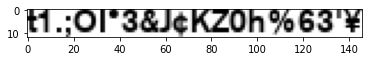

orig: %F¥p[MGyu#ZI¢tQ)#l5y,	pred: %F¥p[MGyu#Zl¢tQ)#l5y


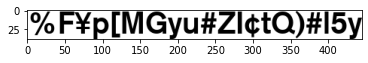

orig: cYeQ3v%O&~%c=IHqq&$d,	pred: cYeQ3v%O&~%c=lHqq&$d


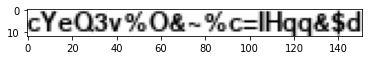

orig: oyx¥yo%¥+9YZ)lGkI9{u,	pred: oyx¥yo%¥+9YZ)IGkI9{u


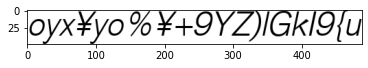

orig: 0AI6NlL}@hQ12p¥}€KvL,	pred: 0Al6NIL}@hQ12p¥}€KvL


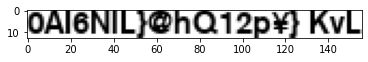

orig: %3x7PxP8#0wvEIIbUDy¥,	pred: %3x7PxP8#0wvElbUDy¥


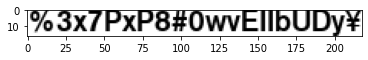

orig: Yg_9}mI1p@]9N°7eaf-_,	pred: Yg_9}mlI1p@]9N°7eaf-_


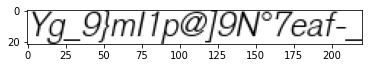

orig: 95{&ZQz7I¥&t`xPA7Rrc,	pred: 95{&ZQz7l¥&t`xPA7Rrc


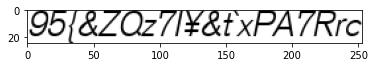

orig: YY$€FN%}m°;l#lijjR#¢,	pred: YY$€FN%}m°;l#IijjR#¢


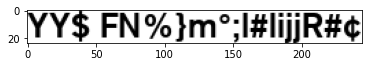

orig: Zlv4{KP{py9zan(I+£P¢,	pred: Zlv4{KP{py9zan(l+£P¢


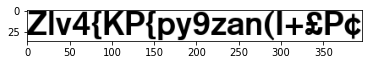

orig: hF6dsEl1b1Rcve($l6q0,	pred: hF6dsEI1b1Rcve($l6q0


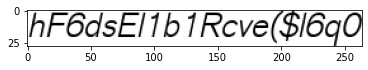

orig: ¥l@[ijf]B$£TenfG^+`i,	pred: ¥I@[ijf]B$£TenfG^+i


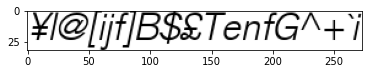

orig: Msyts7N[_h£,,rqYH¥YY,	pred: Msyts7N[_h£,rqYH¥YY


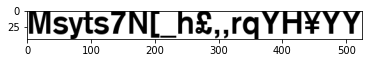

orig: pK}1GrZhV5¥QfvlK2g0F,	pred: pK}1GrZhV5¥QfvIK2g0F


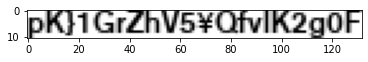

orig: e@lS46'ZxCPN1!-i4%°S,	pred: e@IS46'ZxCPN1!-i4%°S


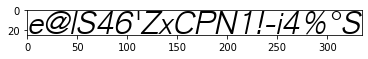

orig: DK£xXB¢i'TQ£BGmcsv}6,	pred: DK£xXBi'TQ£BGmcsv}6


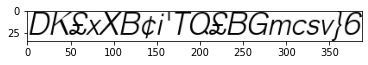

orig: I€_RWjiQV+D=Oe;tihq7,	pred: l€_RWjiQV+D=Oe;tihq7


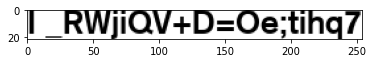

orig: +Bq¥(.t`fNo46%°V!0Mp,	pred: +Bq¥(.t'fNo46%°V!0Mp


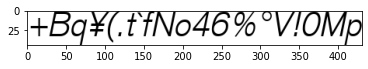

orig: wutZ0kYnOAGp(Imed4n$,	pred: wutZ0kYnOAGp(lmed4n$


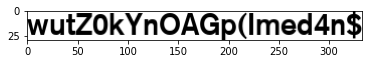

orig: 8i5£mMNirYd'2VklGZb+,	pred: 8i5£mMNirYd'2VkIGZb+


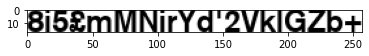

orig: SIWN%[2¢e1LF6HaTT¢5},	pred: SlWN%[2¢e1LF6HaTT¢5}


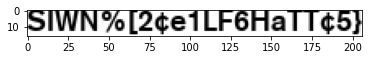

orig: Eo,LBTcr(9g5~BWPbII¥,	pred: Eo,LBTcr(9g5~BWPblI¥


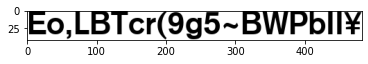

orig: 1zB,1,`7;TBl51XPhXE;,	pred: 1zB,1,`7;TBI51XPhXE;


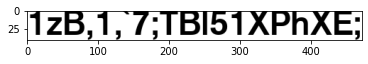

orig: YW}+.¢_r°ss~dGds`s_A,	pred: YW}+.¢_r°s~dGds`s_A


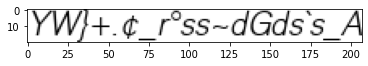

orig: #¥R%r'((I¥KGzHNrcv3q,	pred: #¥R%r'(I¥KGzHNrcv3q


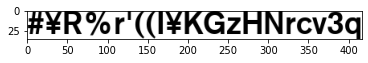

orig: yr)LkluWYh6vxam){[8X,	pred: yr)LkIuWYh6vxam){[8X


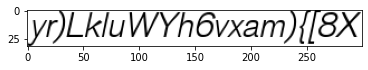

orig: NL~Z3£}77fvHu_Y!V4~1,	pred: NL~Z3£}7fvHu_Y!V4~1


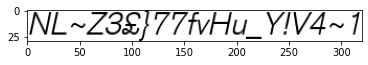

orig: ,9BO2LQstduKSY7Y@ItE,	pred: ,9BO2LQstduKSY7Y@ltE


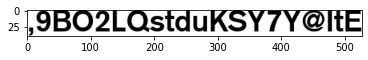

orig: C#O+=I7WD}'9_vXv1f)X,	pred: C#O+=l7WD}'9_vXv1f)X


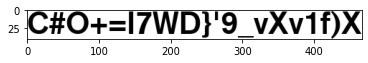

orig: G#UIy,fk{bTiito{f2U3,	pred: G#UIy,fk{bTito{f2U3


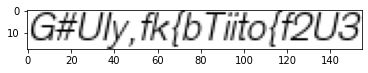

orig: Ya&L¢2.Wk{BF¥=FK'tta,	pred: Ya&L¢2.Wk{BF¥=FK'ta


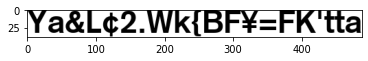

orig: @!WCWnI&2ZPZN@Ru-2wc,	pred: @!WCWnI&2ZPZN@Ru-2wp


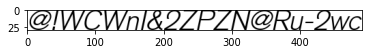

orig: oKF9mZ`m-t..idNo`n!w,	pred: oKF9mZ`m-t.idNo`n!w


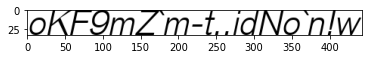

orig: TZYviG375#%°l.IEwwb%,	pred: TZYviG375#%°,jEwwb%


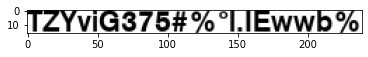

orig: t9cw&I-lmp1x;Mof%v¢F,	pred: t9cw&l-Imp1x;Mof%v¢F


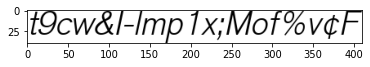

orig: ypSMI`'mwh(€SOe£-csS,	pred: ypSMl`'mwh(€SOe£-csS


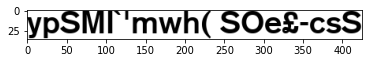

orig: RmJ8r¥€N%8;[Dsp+t;jZ,	pred: RmJ8r¥€N%8;[Dsp+tjZ


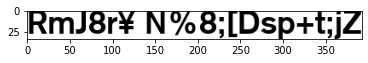

orig: £]qvHR28A(C9A1]'#f[),	pred: £]qvHR28A(C9A1]'#f[


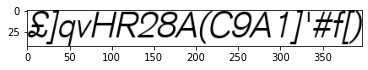

orig: €BwB;i4lkJ8EwqRh2€l;,	pred: €BwB;i4IkJ8EwqRh2€;


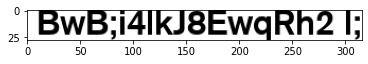

orig: @kl.`,^8-Vr#r£&O.w.y,	pred: @kl`,^8-Vr#r£&O.w.y


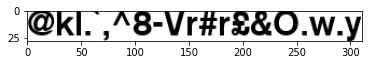

orig: pV~2Gzd+^£lDyDk{l3Cw,	pred: pV~2Gzd+^£IDyDk{l3Cw


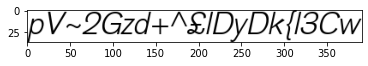

orig: 6P3°dJ€If^H7z{dgTD+w,	pred: 6P3°dJ€lf^H7z{dgTD+w


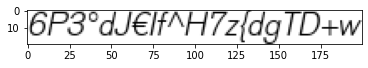

orig: +HU!rN@10g~iFSMv3EGk,	pred: +H!rN@10g~iFSMv3EGk


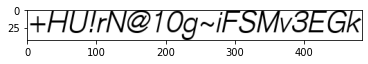

orig: 'in€qF¢}eQAK##w);Kbu,	pred: 'n€qF¢}eQAK##w);Kbu


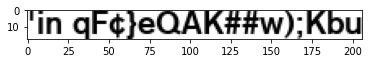

orig: 1SaaInJ3^O70^b[k1mcS,	pred: 1SaInJ3^O70^b[k1mcS


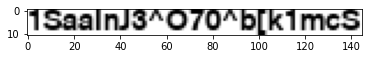

orig: &LCX#uS-IFV49%yX+MJu,	pred: &LCX#uS-lFV49%yX+MJu


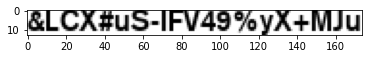

orig: UROKg[K-rOZsLSZ_a1.g,	pred: UROKg[KrOZsLSZ_a1.g


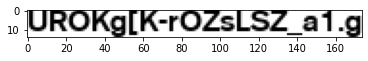

orig: `Oxk)i}YghtQ))`-cw@`,	pred: `Oxk)}YghtQ))`-cw@`


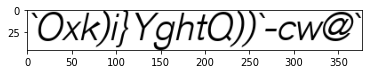

orig: FkuW2gjjvB!£9HyMUt_h,	pred: FkuW2gjvB!£9HyMUt_h


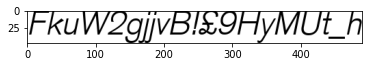

orig: Tx&IhCf6[BlNK#AR,Za^,	pred: Tx&IhCf6[BINK#AR,Za^


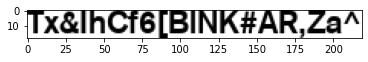

orig: 8JCTWlCB}5)HS!k@Nx`{,	pred: 8JCTWICB}5)HS!k@Nx`{


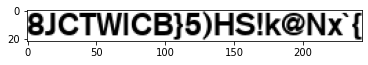

orig: °€_jvlVn6¥¢C+.Fd_Fl[,	pred: °€_jvIVn6¥¢C+.Fd_FI[


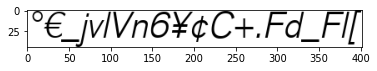

orig: XH!hn€xMQ9;[ohObpllI,	pred: XH!hn€xMQ9;[ohObpl


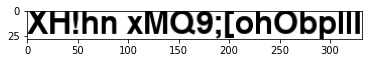

orig: ';GfkyD1YsEEl2)SUT,_,	pred: ';GfkyD1YsEEI2)SUT,_


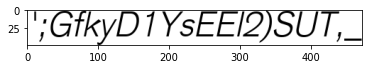

orig: €l^5£Qq`ug2T#Y-klPJ3,	pred: €^5£Qq`ug2T#Y-klPJ3


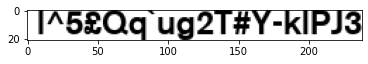

orig: ,X$IJb&HRRCY-_jN(1FM,	pred: ,X$lJb&HRRCY-_jN(1FM


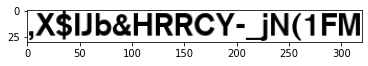

orig: i7p#&B-Gm^€,m-UX9o°2,	pred: l7p#&B-Gm^€,m-UX9o°2


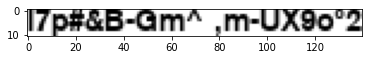

orig: siPIO¥LXU,%AgLxCR`jD,	pred: siPIO¥LXU,%AgLxCRjD


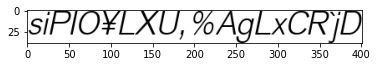

orig: G+25€xIh!dmtn+s&N{wl,	pred: G+25€xlh!dmtn+s&N{wI


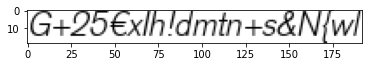

orig: `°$L-@V#n+Hbc4rBf€wv,	pred: `°$L-@V#n+Hbc4rBf€w


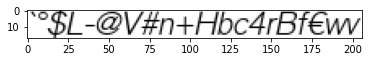

orig: l3NCPklQ9€{}B0y@°j°l,	pred: l3NCPklQ9€{}B0y@°j°I


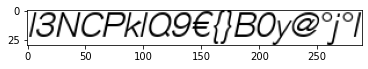

orig: J{0qc{WS0PMg&S@x~IF2,	pred: J{0qc{WS0PMg&S@x~lF2


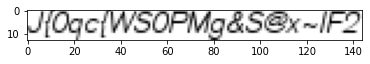

orig: }tDut#.j'l$Jz9dSeeK%,	pred: }tDut#.j'I$Jz9dSeeK%


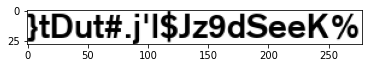

orig: r3mc°x.)¥`.}°5lKr9-L,	pred: r3mc°x.)¥`.}°5iKrO~L


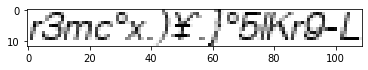

orig: lSTnimAIIS2a¥{&pe,F1,	pred: ISTnimAIS2a¥{&pe,F1


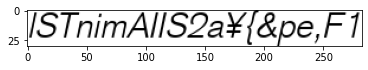

orig: M4A[V=nt(uZt=d,I&oO(,	pred: M4A[V=nt(uZt=d,l&oO(


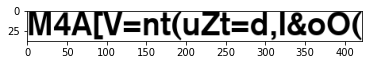

orig: YflWk0oI£h'AX-6o{'{M,	pred: YflWk0oI£h'AX-6o{'`{M


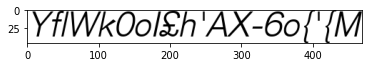

orig: 7&Ih6m¢mj€NWWR¥Chh1^,	pred: 7&lh6m¢mjNWWR¥Chh1^


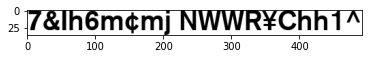

orig: !Li`5~NqrK_w;=4kd0sB,	pred: !L`5~NqrK_w;=4kd0sB


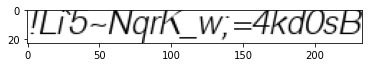

orig: Twm3a1[tOs#€4I€B^R£.,	pred: Twm3a1[tOs#€4l€B^R£.


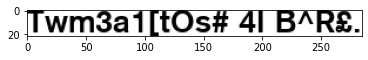

orig: #X!9!O$(MgsLlF0!^PK5,	pred: #X!9!O$(MgsLIF0!^PK5


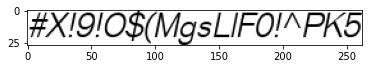

orig: {Co+SV^l3m$°€o;DX{°k,	pred: {Co+SV^I3m$°€o;DX{°k


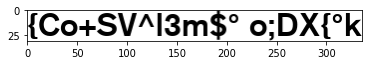

orig: @;v`]$wj1Z.5~Olp#Zj$,	pred: @;v`]$wj1Z.5~OIp#Zj$


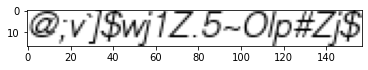

orig: wfYpW.,gR°I¢MP$w%g°B,	pred: wfYpW.,gR°l¢MP$w%g°B


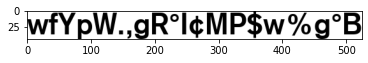

orig: _W=dHZHwZUYD![GD]V[',	pred: _W=dHZHwZUYD![GD]V'


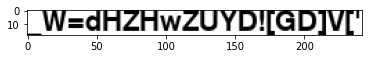

orig: fr,_.G6R,V47lB)Mk(;7,	pred: fr,_.G6R,V47IB)Mk(;7


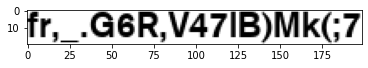

orig: R@ug)5€WL¥tiji._¥qHM,	pred: R@ug)5€WL¥tji_¥qHM


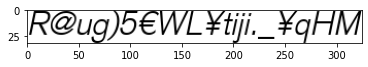

orig: ¢l(q~7i'°[56c){b0k(h,	pred: ¢I(q~7i'°[56c){b0k(h


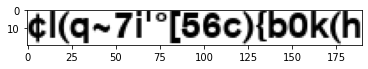

orig: =.'Im@-o;BM4y!iMC%°Z,	pred: =.'lIm@-o;BM4y!iMC%°Z


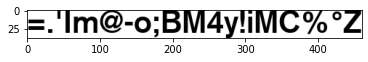

orig: %i[C8I&NRjRy=k7'''!p,	pred: %i[C8I&NRjRy=k7'!p


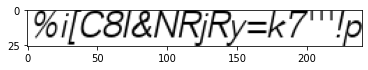

orig: 1tUC9b~${C}MCI@p~6%=,	pred: ftUC9b~${C}MCI@p~6%=


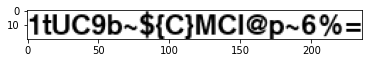

orig: ]9w]xZjd3u)1Lsw_^Ei.,	pred: ]9w]xZjd3u)1Lsw_^El.


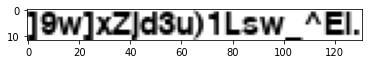

orig: [ZE#kB`Mr^kl5K-!;HSa,	pred: [ZE#kB`Mr^kI5K-!;HSa


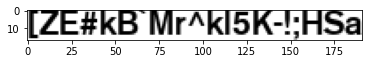

orig: GyZPLUy^KHcW&AskO6N-,	pred: GyZPLUy^KHcW&AskO6Nk


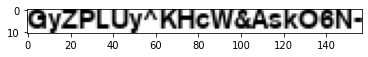

orig: TgdP{Tq8iO30QlJ(.v]O,	pred: TgdP{Tq8iO30QIJ(.v]O


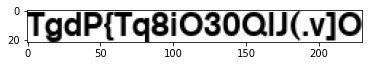

orig: IiD-MylMRRsv%RS;6LdJ,	pred: iD-MylMRRsv%RS;6LdJ


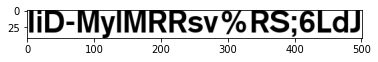

orig: n7uILGBwM@Ap@¥$¥£xNr,	pred: n7ulLGBwM@Ap@¥$¥£xNr


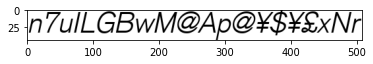

orig: €]&P5N;LAub^vo8lbw9h,	pred: €]&P5N;LAub^vo8Ibw9h


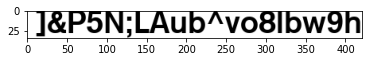

orig: wEITW83°DAWpDelIk@Ka,	pred: wElTW83°DAWpDelIk@Ka


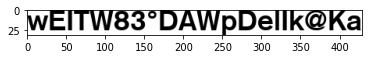

orig: tvo$t{L}p¥6omYEd=BlC,	pred: tvo$t{L}p¥6omYEd=BIC


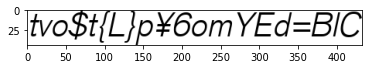

orig: ¢g@=DFUPCAiJq2qqL0=I,	pred: ¢g@=DFUPCAiJq2qqL0=l


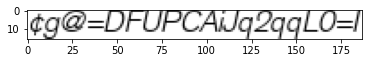

orig: $`-`x]s',GBlQ#8q)7~t,	pred: $`-`x]s',GBIQ#8q)7~t


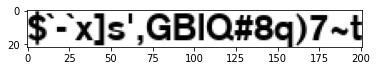

orig: Hf6lzMHlL,ffYrBD,2hS,	pred: Hf6lzMHlL,fYrBD,2hS


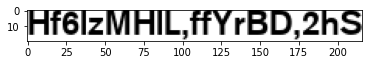

orig: $K,3V!WBR°;(€)~BM°[X,	pred: $K,3V!WBR';(€)~BM°[X


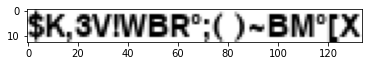

In [134]:
for i, v in enumerate(test):
    if v != pred[i]:
      print(f'orig: {v},\tpred: {pred[i]}')
      img = Image.open(os.path.join(data_path, v +'.png'))
      plt.imshow(img)
      plt.show()